# SVHN Classifier
This is an Image Classifier for SVHN(Street View House Numbers) dataset. Here I have created a transfer learning model to label single digit images (0-9) using fastai library.

In [1]:
from fastai2.vision.all import *
from fastai2.torch_basics import *
from fastai2.data.all import *
from fastai2.vision.core import *
from fastai2.vision.widgets import *
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import h5py
from PIL import Image as image
from scipy.io import loadmat
plt.rcParams['figure.figsize'] = (20.0, 10.0)
%matplotlib inline


# Data Preprocessing
Crop the images around their bounding box and extract single digit images. The bounding boxes for every digit in the image is provided in the dataset.  

In [2]:
class DigitStructWrapper:
    """
    Wrapper for the H5PY digitStruct files from the SVHN dataset
    Creates an array of dictionaries containing the filename and bounding boxes for every digit in the image.
    Adapted from https://github.com/hangyao
    """

    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

    def get_name(self, n):
        """Return the name of the n(th) digit struct"""
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])

    def get_attribute(self, attr):
        """Helper function for dealing with one vs. multiple bounding boxes"""
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

    def get_bbox(self, n):
        """Return a dict containing the data from the n(th) bbox"""
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.get_attribute(self.inf[bb]["height"])
        bbox['label'] = self.get_attribute(self.inf[bb]["label"])
        bbox['left'] = self.get_attribute(self.inf[bb]["left"])
        bbox['top'] = self.get_attribute(self.inf[bb]["top"])
        bbox['width'] = self.get_attribute(self.inf[bb]["width"])
        return bbox

    def get_item(self, n):
        """Return the name and bounding boxes of a single image"""
        s = self.get_bbox(n)
        s['name'] = self.get_name(n)
        return s

    def unpack(self):
        """Returns a list of dicts containing all the bounding boxes"""
        return [self.get_item(i) for i in range(len(self.digitStructName))]

    def unpack_all(self):
        pictDat = self.unpack()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = {'filename': pictDat[i]["name"]}
            figures = []
            for j in range(len(pictDat[i]['height'])):
                figure = {}
                figure['height'] = pictDat[i]['height'][j]
                figure['label'] = pictDat[i]['label'][j]
                figure['left'] = pictDat[i]['left'][j]
                figure['top'] = pictDat[i]['top'][j]
                figure['width'] = pictDat[i]['width'][j]
                figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        return result

In [3]:
def parse_info(start_path = '.'):
    """ Extracts a bounding box file and returns a dictionary
    """
    return DigitStructWrapper(start_path).unpack_all()

# Extract info from mat files such as the bounding boxes
train_bbox = parse_info('/storage/data/SVHN/train/digitStruct.mat')
test_bbox = parse_info('/storage/data/SVHN/test/digitStruct.mat')

# Display the information stored about an individual image
print(json.dumps(train_bbox[0], indent=2))

/opt/conda/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:20: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/opt/conda/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:15: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  from ipykernel import kernelapp as app
/opt/conda/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:22: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


{
  "filename": "1.png",
  "boxes": [
    {
      "height": 219.0,
      "label": 1.0,
      "left": 246.0,
      "top": 77.0,
      "width": 81.0
    },
    {
      "height": 219.0,
      "label": 9.0,
      "left": 323.0,
      "top": 81.0,
      "width": 96.0
    }
  ]
}


In [3]:
def dict_to_df(image_bounding_boxes, path, source):
    """ Helper function for flattening the bounding box dictionary
    """
    # Store each bounding box
    boxes = []
    
    # For each set of bounding boxes
    for image in image_bounding_boxes:
        
        # For every bounding box
        for bbox in image['boxes']:
            
            # Store a dict with the file and bounding box info
            boxes.append({
                    'filename': source+'/'+image['filename'],
                    'label': bbox['label'],
                    'width': bbox['width'],
                    'height': bbox['height'],
                    'top': bbox['top'],
                    'left': bbox['left'],
                    'source':source})
            
    # return the data as a DataFrame
    return pd.DataFrame(boxes)


# Save bounding box data to csv
bbox_file = '/storage/data/SVHN/bounding_boxes.csv'

if not os.path.isfile(bbox_file):
    
    # Extract every individual bounding box as DataFrame  
    train_df = dict_to_df(train_bbox, '/storage/data/SVHN/train/','train')
    test_df = dict_to_df(test_bbox, '/storage/data/SVHN/test/','test')
   # extra_df = dict_to_df(extra_bbox, 'data/extra/')

    print("Training", train_df.shape)
    print("Test", test_df.shape)
    #print("Extra", extra_df.shape)
    print('')

    # Concatenate all the information in a single file
    df = pd.concat([train_df, test_df])
    
    print("Combined", df.shape)

    # Write dataframe to csv
    df.to_csv(bbox_file, index=False)

    # Delete the old dataframes to save memory
    del train_df, test_df, train_bbox, test_bbox
    
else:
    # Load preprocessed bounding boxes
    df = pd.read_csv(bbox_file)
print(df.shape)
# Display the first 5 rows of dataframe
df.head()

,filename,label,width,height,top,left,source
0,train/1.png,1.0,81.0,219.0,77.0,246.0,train
1,train/1.png,9.0,96.0,219.0,81.0,323.0,train
2,train/2.png,2.0,23.0,32.0,29.0,77.0,train
3,train/2.png,3.0,26.0,32.0,25.0,98.0,train
4,train/3.png,2.0,8.0,15.0,5.0,17.0,train


In [5]:
df1 = df[['filename','label','source']]

In [6]:
#Extract the number of digits in each image and aggregate the rows to get labels
df1 = df1.groupby(['filename','source']).aggregate({'count',
                                         lambda x:list(x)}).reset_index()
df1.columns=['filename','source','num_digits','labels']
print(df1.shape)
df1.head()

In [10]:
# Calculate x and y (upper bounds for bounding box)
df['x'] = df['left'] + df['width']
df['y'] = df['top'] + df['height']

# Perform the following aggregations on the columns
aggregate = {'left':'min',
             'top':'min',
             'x':'max',
             'y':'max'
                }

# Apply the aggegration
df = df.groupby('filename').agg(aggregate).reset_index()

print(df.shape)
df.head()

In [13]:
df = df.merge(df1)

In [14]:
df = df.rename(columns={'left':'X0','top':'Y0','x':'X1','y':'Y1'})

In [15]:
df.head()

,filename,X0,Y0,X1,Y1,source,num_digits,labels
0,test/1.png,43.0,7.0,62.0,37.0,test,1,[5.0]
1,test/10.png,16.0,19.0,38.0,40.0,test,2,"[1.0, 6.0]"
2,test/100.png,124.0,65.0,152.0,99.0,test,2,"[6.0, 1.0]"
3,test/1000.png,210.0,59.0,245.0,87.0,test,2,"[2.0, 7.0]"
4,test/10000.png,35.0,11.0,66.0,32.0,test,3,"[1.0, 4.0, 3.0]"


In [16]:
#helper function to convert values in the list to string (label)
def convert_str(x):
    s=''
    for i in x:
        if i == 10: i=0
        s= s+str(int(i))
        
    return (s)

In [17]:
df['label'] = df['labels'].apply(lambda x:convert_str(x))

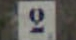

In [19]:
Image.open('/storage/data/SVHN/train/10122.png')

In [20]:
#create train dataset for single digit images
df_train = df[(df.source == 'train') & (df.num_digits ==1)][['filename','X0','Y0','X1','Y1','label']]

In [21]:
df_train['label'].unique()

array(['6', '4', '3', '1', '0', '9', '5', '7', '2', '8'], dtype=object)

In [22]:
#helper function to crop the original images around their bounding boxes
def crop_bbox(url,left,upper,right,lower):
    im = image.open('/storage/data/SVHN/'+url)
    tempImage = im.crop((left,upper,right,lower))
    newPath = url.split(".")[0]+"_Cropped" + "." + url.split(".")[1]
    tempImage.save('/storage/data/SVHN/'+newPath)
    w,h=tempImage.size
    return (newPath,w,h)

In [23]:
df_train[['newPath','width','height']] = df_train.apply(lambda x : pd.Series(crop_bbox(x.filename,x.X0,x.Y0,x.X1,x.Y1)),axis=1)

In [24]:
df_train.describe()

,X0,Y0,X1,Y1,width,height
count,5137.000000,5137.000000,5137.000000,5137.000000,5137.000000,5137.000000
mean,41.452988,7.903640,60.456881,42.825968,19.003893,34.922328
std,27.466706,8.509699,38.369161,27.685710,13.777803,22.354471
min,-1.000000,0.000000,7.000000,11.000000,3.000000,9.000000
25%,25.000000,3.000000,36.000000,26.000000,11.000000,21.000000
50%,34.000000,6.000000,50.000000,36.000000,15.000000,29.000000
75%,49.000000,10.000000,72.000000,51.000000,23.000000,42.000000
max,288.000000,142.000000,495.000000,395.000000,207.000000,346.000000


In [25]:
#Create the final train dataset for single digit cropped images
df_train_cropped= df_train[['newPath','label']]

# From data to DataLoaders
 Now we have the training data and that needs to converted into a DataLoaders object. DataLoaders is a thin class that helps with data augmentation and makes the data available as train and valid. 
Here we need all the images to have same dimensions so that they could colate into tensors to be passed to the GPU. I then resize the image to a larger dimension than the target training dimensions . This creates image that can have spare margin for further augementation without creating empty spaces.The image is randomly cropped keeping 75% of  image in the frame and is resized to 64.   

In [98]:
data_squish = ImageDataLoaders.from_df(df_train_cropped,
                                Path('/storage/data/SVHN'),
                                splitter=RandomSplitter(valid_pct=0.3, seed=42),
                                item_tfms=Resize(128,method = ResizeMethod.Pad,pad_mode=PadMode.Border),
                                batch_tfms=aug_transforms(size=64, min_scale=0.75,do_flip=False)       
                                )

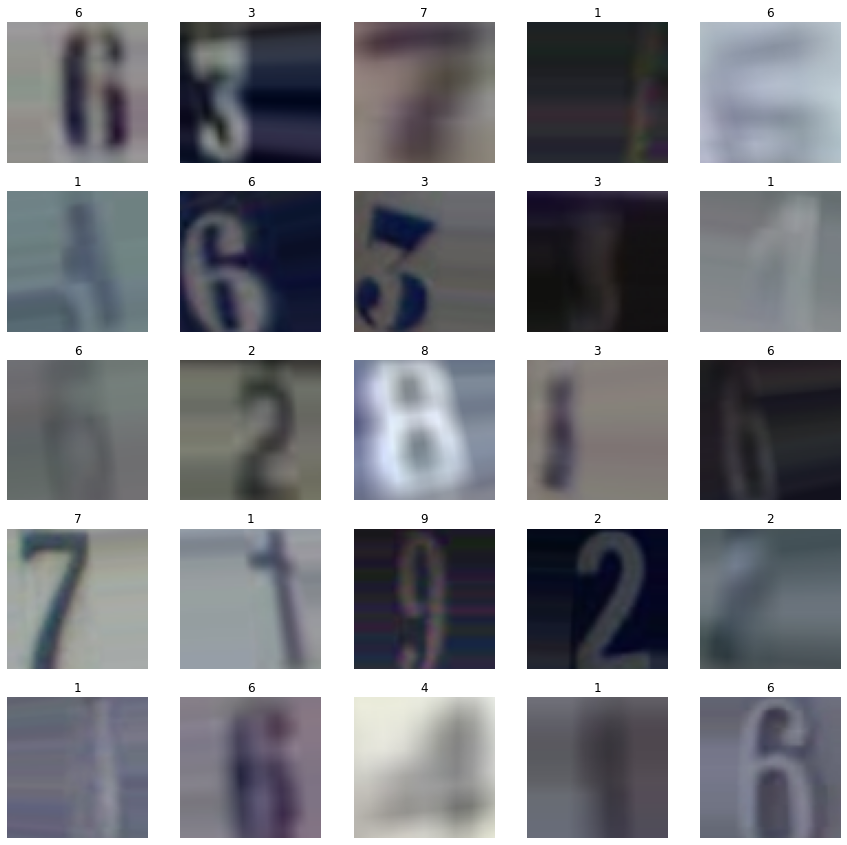

In [99]:
data_squish.train.show_batch(max_n=30, ncols=5)

# Unfreezing and Transfer Learning
The final layer of the convolutional neural network for resnet18 is unlikely to be of any use for classifying the SVHN dataset in transfer learning setting, because it is specifically designed to classify the images in the original pretraining dataset. So in transfer learning we replace the final layer with a new linear layer which will have the correct number of outputs for our desired task. In this case there will be 10 categories (0-9). 

This new linear layer will have random weights therefore our model will have random outputs before we fine tune it. This does not mean that the model is random, all the layers except the newly added one have been trained to be good at image classification. Now the model needs to be trained in such a way that it remembers what it has learnt from the pretrained model and use it solve our problem. In order to achieve this we have to tell the model to adjust the weights only for the newly added layer and not to change the weights in the rest of the neural network. This is called freezing those pretrained layers.

Here we first train the randomly added layer for 10 epochs with all the other layers frozen and then unfreeze all the layers and train the model for 45 epochs.

In [100]:
learn = cnn_learner(data_squish, resnet18, metrics=error_rate)

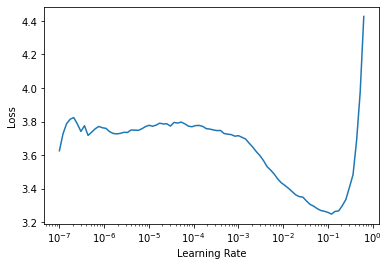

In [101]:
lr_min,lr_steep = learn.lr_find()

In [102]:
learn.fit_one_cycle(10, 5e-4)

epoch,train_loss,valid_loss,error_rate,time
0,3.567551,2.481255,0.818890,00:40
1,3.023412,1.932197,0.637780,00:40
2,2.532590,1.718498,0.551120,00:40
3,2.188354,1.575748,0.514119,00:41
4,1.909662,1.449804,0.469328,00:40
5,1.735224,1.401451,0.448880,00:40
6,1.593332,1.337171,0.440117,00:40
7,1.534865,1.301336,0.423564,00:40
8,1.498291,1.304556,0.426485,00:39
9,1.477555,1.293681,0.417722,00:40


In [103]:
learn.unfreeze()

(0.00036307806149125097, 3.019951861915615e-07)

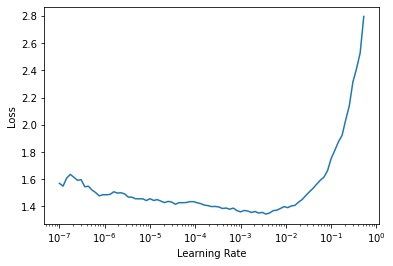

In [104]:
learn.lr_find()

In [105]:
learn.fit_one_cycle(45, lr_max= 1e-4)

epoch,train_loss,valid_loss,error_rate,time
0,1.477178,1.237008,0.398247,00:55
1,1.421082,1.211580,0.387537,00:53
2,1.340005,1.110182,0.355404,00:54
3,1.220246,0.985501,0.315482,00:55
4,1.081660,0.866313,0.281402,00:53
5,0.936857,0.780949,0.243427,00:55
6,0.829125,0.716484,0.225901,00:53
7,0.732814,0.630900,0.201558,00:54
8,0.632406,0.596533,0.175268,00:53
9,0.535999,0.558202,0.158715,00:54


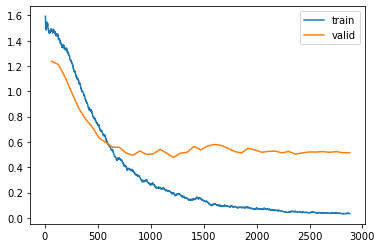

In [106]:
learn.recorder.plot_loss()

# Model Interpretation

This is a confusion matrix for all 10 categories. The model seems to be performing well with an accuracy of 89% on the validation dataset. 

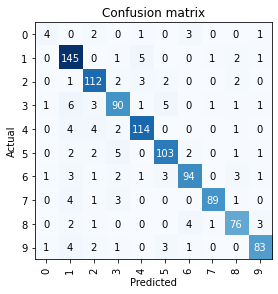

In [107]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Here are top 20 misclassified images. Here we can see some have been labeled incorrectly in the original dataset whereas the model identified them correctly and some are too blurred to be labeled correctly. This gives us some assurance that we are on right track. Some more data augmentation, deeper architecture and training for more epochs can help us further improve the accuracy of our model.

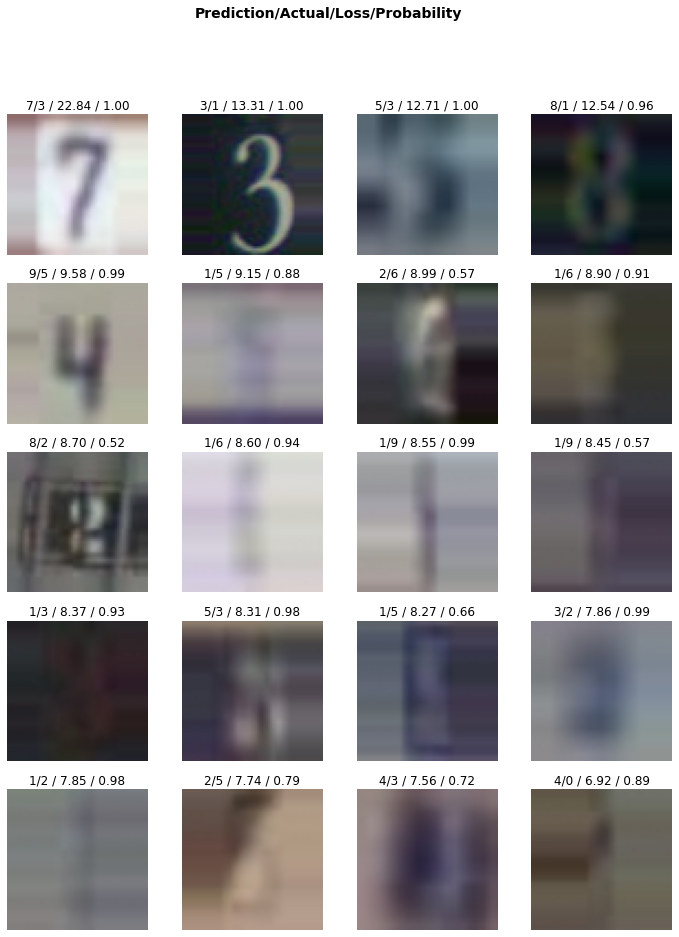

In [108]:
interp.plot_top_losses(20, nrows=5)

# Prediction on Test Data

The images in test data are cropped around their respective bounding boxes and are then classified. The test set has an accuracy of 90.2% using the current model.


In [109]:
#test
df_test = df[(df.source == 'test') & (df.num_digits ==1)][['filename','X0','Y0','X1','Y1','label']]
df_test[['newPath','width','height']] = df_test.apply(lambda x : pd.Series(crop_bbox(x.filename,x.X0,x.Y0,x.X1,x.Y1)),axis=1)

In [110]:
print(df_test.shape)
df_test.head()

(2483, 9)


,filename,X0,Y0,X1,Y1,label,newPath,width,height
0,test/1.png,43.0,7.0,62.0,37.0,5,test/1_Cropped.png,19,30
9,test/10005.png,27.0,7.0,38.0,28.0,1,test/10005_Cropped.png,11,21
26,test/10020.png,30.0,6.0,54.0,34.0,9,test/10020_Cropped.png,24,28
35,test/10029.png,45.0,15.0,63.0,39.0,4,test/10029_Cropped.png,18,24
36,test/1003.png,260.0,89.0,286.0,122.0,7,test/1003_Cropped.png,26,33


In [111]:
def predict_labels(path):
    pred,pred_idx,probs = learn.predict('/storage/data/SVHN/'+path)
    return (pred,float(probs[pred_idx]))

In [ ]:
df_test[['prediction','probability']] = df_test.apply(lambda x : pd.Series(predict_labels(x.newPath)),axis=1)

In [114]:
accuracy = len(df_test[df_test.label == df_test.prediction])/len(df_test)
print(f"Accuracy = {accuracy*100:.04f}")

Accuracy = 90.2537
